# Difftest Results

Connect to results database:

In [1]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd
from collections import OrderedDict

def get_stats(s, tables, testbed_id, no_opt):
    param_ids = s.query(tables.params.id)\
        .filter(tables.params.optimizations == no_opt)

    generation_time = tables.programs.runtime
    runtime = tables.results.runtime
    reduction_time = sql.sql.func.ifnull(tables.reductions.runtime, 0)
    result_time = generation_time + runtime + reduction_time

    q = s.query(sql.sql.func.count(tables.results.id), sql.sql.func.sum(result_time))\
        .join(tables.programs).outerjoin(tables.reductions)\
        .filter(tables.results.testbed_id == testbed_id,
                tables.results.params_id.in_(param_ids))
    num_results, total_time = q.first()
    return num_results, total_time


def get_rows(s, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    
    clsmith_noopt_results, clsmith_noopt_time = get_stats(s, CLSMITH_TABLES, testbed_id, True)
    clsmith_results, clsmith_time = get_stats(s, CLSMITH_TABLES, testbed_id, False)

    clgen_noopt_results, clgen_noopt_time = get_stats(s, CLGEN_TABLES, testbed_id, True)
    clgen_results, clgen_time = get_stats(s, CLGEN_TABLES, testbed_id, False)
    
    r1 = OrderedDict()
    r1["Device"] = device_str(testbed.device)
    r1["±"] = "-"
    r1["CLSmith time"] = clsmith_noopt_time
    r1["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_noopt_time / 3600)
    r1["CLSmith results"] = clsmith_noopt_results
    r1["CLgen time"] = clgen_noopt_time
    r1["CLgen time (hrs)"] = "{:.1f}h".format(clgen_noopt_time / 3600)
    r1["CLgen results"] = clgen_noopt_results
    
    r2 = OrderedDict()
    r2["Device"] = device_str(testbed.device)
    r2["±"] = "+"
    r2["CLSmith time"] = clsmith_time
    r2["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_time / 3600)
    r2["CLSmith results"] = clsmith_results
    r2["CLgen time"] = clgen_time
    r2["CLgen time (hrs)"] = "{:.1f}h".format(clgen_time / 3600)
    r2["CLgen results"] = clgen_results
    
    return r1, r2


rows = []
with Session(commit=False) as s:
    for config_id, testbed_id in CONFIGURATIONS:
        rows += get_rows(s, testbed_id)
overview_table = pd.DataFrame(rows)
overview_table

,Device,±,CLSmith time,CLSmith time (hrs),CLSmith results,CLgen time,CLgen time (hrs),CLgen results
0,GeForce GTX 1080,-,247018.889571,68.6h,21000,173542.960828,48.2h,60637
1,GeForce GTX 1080,+,224885.826677,62.5h,21000,192057.124516,53.3h,66777
2,GeForce GTX 780,-,205346.184916,57.0h,21000,44567.226974,12.4h,22051
3,GeForce GTX 780,+,198831.193807,55.2h,21000,42486.631288,11.8h,22051
4,Intel HD Haswell GT2,-,443975.369190,123.3h,15987,82321.791595,22.9h,63952
5,Intel HD Haswell GT2,+,217990.425388,60.6h,7957,62139.093180,17.3h,48715
6,Intel E5-2620 v4,-,190422.024907,52.9h,21000,100636.045759,28.0h,61474
7,Intel E5-2620 v4,+,207719.975833,57.7h,21000,112236.854590,31.2h,67651
8,Intel E5-2650 v2,-,241560.881544,67.1h,21000,42204.647540,11.7h,22130
9,Intel E5-2650 v2,+,201940.933873,56.1h,21001,43282.203163,12.0h,22130


## Schedule

In [21]:
MIN_TIME = 48 * 3600

schedule = []
for _, row in overview_table.iterrows():
    for source in ["CLSmith", "CLgen"]:
        if row[f"{source} time"] < MIN_TIME:
            d = OrderedDict()
            d["Device"] = row["Device"]
            d["±"] = row["±"]
            d["Job"] = source
            d["Remaining time"] = (MIN_TIME - row[f"{source} time"])
            d["Remaining time (hours)"] = "{:.1f}h".format((MIN_TIME - row[f"{source} time"]) / 3600)
            schedule.append(d)
    
schedule = pd.DataFrame(schedule)
schedule.sort_values(by="Remaining time", ascending=False)

,Device,±,Job,Remaining time,Remaining time (hours)
14,Intel E5-2620 (ComputeAorta),-,CLgen,141580.136264,39.3h
16,Intel E5-2620 (ComputeAorta),+,CLgen,140417.539110,39.0h
8,Intel i5-4570,-,CLgen,135416.619240,37.6h
6,Intel E5-2650 v2,-,CLgen,130595.352460,36.3h
1,GeForce GTX 780,+,CLgen,130313.368712,36.2h
7,Intel E5-2650 v2,+,CLgen,129517.796837,36.0h
0,GeForce GTX 780,-,CLgen,128232.773026,35.6h
9,Intel i5-4570,+,CLgen,125630.390904,34.9h
3,Intel HD Haswell GT2,+,CLgen,110660.906820,30.7h
11,Intel Xeon Phi,+,CLgen,90547.799218,25.2h


## Testing Time

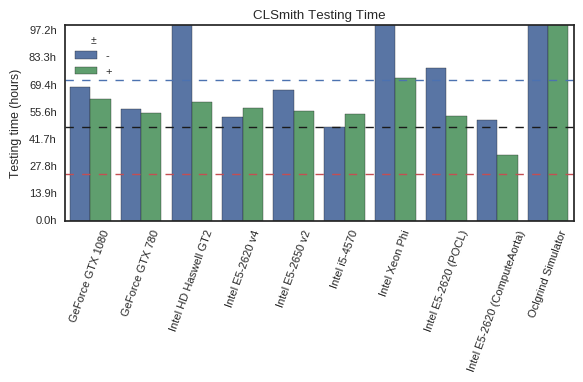

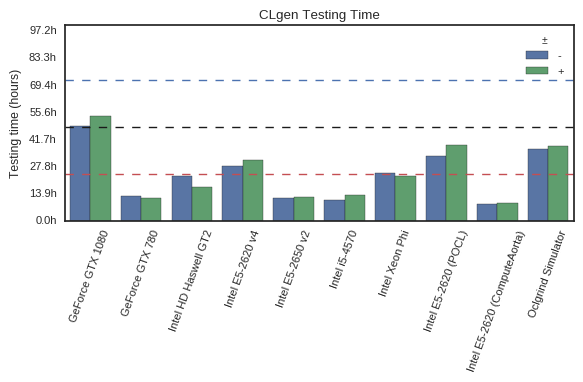

In [20]:
def plot_testing_time(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.set_ylim((0, 100 * 3600))
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}h".format(x / 3600)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    plt.axhline(y=24 * 3600, color="r", lw=1, linestyle="--")
    plt.axhline(y=48 * 3600, color="k", lw=1, linestyle="--")
    plt.axhline(y=72 * 3600, color="b", lw=1, linestyle="--")

    viz.finalise(figsize=(6, 4))

plot_testing_time(overview_table, "CLSmith time", "CLSmith Testing Time")
plot_testing_time(overview_table, "CLgen time", "CLgen Testing Time")

## Number of Results

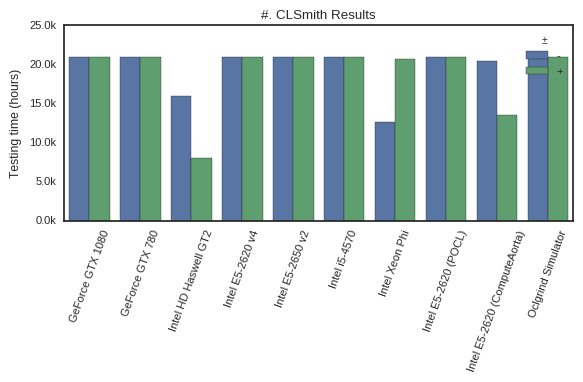

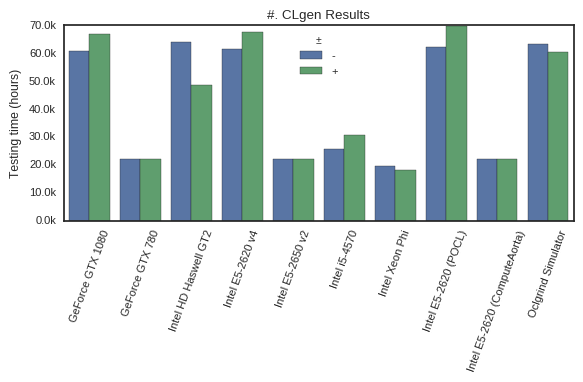

In [18]:
def plot_num_results(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}k".format(x / 1000)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    viz.finalise(figsize=(6, 4))

plot_num_results(overview_table, "CLSmith results", "#. CLSmith Results")
plot_num_results(overview_table, "CLgen results", "#. CLgen Results")

## Testbeds

In [ ]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict


def get_platform_stats(s, testbed: Testbed):
    submitable_results = [coCLgenResult, cl_launcherCLgenResult, CLgenResult]
    def get_submitted(table):
        """ submitted, non-duplicate bugs """
        return s.query(table)\
            .filter(table.testbed_id == testbed.id,
                    table.submitted == 1,
                    table.dupe != 1).count()

    runtime_tables = [coCLgenResult, cl_launcherCLgenResult]  # CLgenResult done separately
    def get_runtime(table):
        return s.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).first()[0] or 0

    clgen_time = sum(overview_table.loc[overview_table["Device"] == device_str(testbed.device)]["CLgen time"].values)

    return (
        sum(get_runtime(table) for table in runtime_tables) + clgen_time,
        sum(get_submitted(table) for table in submitable_results),
    )


def get_row(s, config_id, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = device_str(testbed.device)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    runtime, submitted = get_platform_stats(s, testbed)
    d["Testing time"] = "{:.0f} hours".format(round(runtime / 3600))
    d["B.R. Submitted"] = submitted
    return d

with Session(commit=False) as s:
    rows = [get_row(s, *x) for x in CONFIGURATIONS]
table = pd.DataFrame(rows)
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ cllllll | rr }}
\\toprule
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Testing time}} & \\textbf{{Bugs Submitted}} \\\\
\\midrule""", file=outfile)
    for row in rows:
        print(" & ".join([str(x) for x in row.values()]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

In [ ]:
%run mkmegatable.ipy

## Runtimes

In [ ]:
clgen_generation_time = .9

def get_runtimes():
    TIMEOUT = 60
    
    with Session(commit=False) as s:
        # CLSmith times
        q = s.query(
                CLSmithResult.runtime, 
                CLSmithProgram.runtime, 
                sql.sql.func.ifnull(CLSmithReduction.runtime, 0))\
            .outerjoin(CLSmithProgram)\
            .outerjoin(CLSmithReduction)\
            .filter(CLSmithResult.classification != None)
        clsmith_times = np.array([row for row in q])

        # CLgen times
        q = s.query(
                CLgenResult.runtime,
                CLgenProgram.runtime + CLgenHarness.generation_time,
                sql.sql.func.ifnull(CLgenReduction.runtime, 0))\
            .outerjoin(CLgenProgram)\
            .outerjoin(CLgenHarness)\
            .outerjoin(CLgenReduction)\
            .filter(CLgenResult.classification != None)
        clgen_times = np.array([row for row in q])

    table = (
        [("Execution", x, "CLSmith") for x in clsmith_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLSmith") for x in clsmith_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLSmith") for x in clsmith_times[:,2] if x > 0] +
        [("Execution", x, "CLgen") for x in clgen_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLgen") for x in clgen_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLgen") for x in clgen_times[:,2] if x > 0])
    table = pd.DataFrame(table, columns=["Name", "Runtime (s)", "Source"])
    return table

runtimes_table = get_runtimes()

In [ ]:
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
    # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(runtimes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(runtimes_table, fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Kernel sizes

In [ ]:
sns.set(style="ticks")
from collections import defaultdict

def get_kernel_sizes():
    TIMEOUT = 60
    
    with Session(commit=False) as s:
        # CLSmith times
        clsmith = s.query(
                CLSmithResult.classification,
                sql.sql.func.ifnull(CLSmithReduction.src, CLSmithProgram.src))\
            .outerjoin(CLSmithProgram)\
            .outerjoin(CLSmithReduction)\
            .filter(CLSmithResult.classification != None)#,
    #                CLSmithResult.classification != "pass")

        clgen = s.query(
                CLgenResult.classification,
                sql.sql.func.ifnull(CLgenReduction.src, CLgenProgram.src))\
            .outerjoin(CLgenProgram)\
            .outerjoin(CLgenReduction)\
            .filter(CLgenResult.classification != None),
    #                CLgenResult.classification != "pass")
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

kernel_sizes_table = get_kernel_sizes()

In [ ]:
def plot_kernel_sizes(table, *args, **kwargs):
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(kernel_sizes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(kernel_sizes_table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

In [ ]:
def get_totaltimes():
    
    def _t(s, results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = s.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    with Session(commit=False) as s:
        clsmith_times = _t(s, CLSmithResult, CLSmithProgram, CLSmithReduction)
        clgen_times = _t(s, CLgenResult, CLgenProgram, CLgenReduction)

    return clsmith_times, clgen_times

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push